In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# must have gradientlab installed locally - see README

In [1]:
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer
from gradientlab.data_utils.experiment_path import get_ckpt_path_by_exp_name

/media/mascit/data/Projects/python/gradientlab/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_name = Path(".").resolve().absolute().name
ckpt_path = get_ckpt_path_by_exp_name(exp_name)
exp_name

'exp20251109_0_lm_kda_20m_nucleotides_std'

In [38]:
model = AutoModelForCausalLM.from_pretrained(ckpt_path, trust_remote_code=True).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(ckpt_path)

In [39]:
inputs = tokenizer(["<|im_start|>CGGAGCTGTCTCCGTGGCCTTGG | BE39:MELJUSO:zscore >"], return_tensors="pt", add_special_tokens=False, return_attention_mask=False)
inputs

{'input_ids': tensor([[259,  70,  74,  74,  68,  74,  70,  87,  74,  87,  70,  87,  70,  70,
          74,  87,  74,  74,  70,  70,  87,  87,  74,  74,  35, 127,  35,  69,
          72,  54,  60,  61,  80,  72,  79,  77,  88,  86,  82,  61, 125, 118,
         102, 114, 117, 104,  35,  65]])}

In [40]:
inputs = {k: v.to("cuda") for k, v in inputs.items()}
ids = model.generate(**inputs, do_sample=False,  max_length=1200)
tokenizer.decode(ids[0])

'<|im_start|> CGGAGCTGTCTCCGTGGCCTTGG | BE39:MELJUSO:zscore > -0.2 <|im_end|>'

In [41]:
import sys

import torch
from tqdm import tqdm
from gradientlab.experiments.exp20251108_0_lm_kda_20m_nucleotides.torch_dataset import (
    NucleotidesTaskCollate,
    NucleotidesTaskDatasetInference,
)
from datasets import load_from_disk, Dataset
from torch.utils.data import DataLoader

ds = load_from_disk("/media/mascit/datasets/nucleotides_std")

dataset_test = NucleotidesTaskDatasetInference(ds["test"])  # type: ignore
collate_fn = NucleotidesTaskCollate(tokenizer)

device = "cuda"

In [42]:
pbar = tqdm(iter(dataset_test), total=len(dataset_test))
outputs = []
for (prefix, label) in pbar:
    inputs = collate_fn([prefix])
    inputs = {k: v.to(device) for k, v in inputs.items()}
    preds = model.generate(
        **inputs,
        max_length=300,
        do_sample=False,
    )[0].tolist()
    dec = tokenizer.decode(preds)
    outputs.append(dec)

100%|██████████| 2406/2406 [09:02<00:00,  4.44it/s]  


In [18]:
outputs[:10]

['<|im_start|> GGGATGGCTTGTCCTTCTCCAGG | BE39:MELJUSO:zscore > 0.2 <|im_end|>',
 '<|im_start|> CCGGCTGCAGGCCCTGGAGAAGG | BE39:MELJUSO:zscore > 0.5 <|im_end|>',
 '<|im_start|> GGACCTGCAGGAAGCACGCGAGG | BE39:MELJUSO:zscore > 0.2 <|im_end|>',
 '<|im_start|> CCTCCCAGATGATGACCCAGAGG | BE39:MELJUSO:zscore > -0.7 <|im_end|>',
 '<|im_start|> ACTGGAACAGTGAAAAAGGAAGG | BE39:MELJUSO:zscore > -1.5 <|im_end|>',
 '<|im_start|> GCCCTGGGAGAATAGCTGTTGGG | BE39:MELJUSO:zscore > 0.6 <|im_end|>',
 '<|im_start|> CCACTGCACAGGCTACATCAAGG | BE39:MELJUSO:zscore > -2.2 <|im_end|>',
 '<|im_start|> GGTGGAGAGCGTCCGGCAGCCGG | BE39:MELJUSO:zscore > -0.5 <|im_end|>',
 '<|im_start|> ACTGAAACATTTGATCTTGGAGG | BE39:MELJUSO:zscore > -0.6 <|im_end|>',
 '<|im_start|> GGCTGGAGGATGCGGGCGTGCGG | BE39:MELJUSO:zscore > 1.0 <|im_end|>']

In [ ]:
def extract_answer(pred: str):
    try:
        return float(pred.split(" > ")[-1].rstrip("<|im_end|>").strip())
    except:
        return -99

df_test = ds["test"].to_pandas()

df_test["pred"] = outputs
df_test["pred"] = df_test["pred"].apply(extract_answer)

df_test["label_float"] = df_test["label"].astype(float)
len(df_test[df_test["label_float"] == df_test["pred"]]) / len(df_test)
# pretrain + instadeep finetune: 0.0515
# pretrain: 0.066

0.06608478802992519

In [ ]:
len(df_test[df_test["label_float"].round(0) == df_test["pred"].round(0)]) / len(df_test)
# pretrain + instadeep finetune: 0.4474
# pretrain: 0.5299

0.529925187032419

In [ ]:
import math


df_test["pred_is_same_sign"] = df_test.apply(lambda x: math.copysign(1, x["pred"]) == math.copysign(1, x["label_float"]), axis=1)

len(df_test[df_test["pred_is_same_sign"]]) / len(df_test)
# pretrain + instadeep finetune: 0.764
# pretrain: 0.8038

0.8038237738985868

In [46]:
len(df_test[df_test["pred"] == -99])

7

In [ ]:
df_test = df_test[df_test["pred"] != -99]
df_test["mae"] = df_test.apply(lambda x: abs(x["pred"] - x["label_float"]), axis=1)

df_test["mae"].mean()
# pretrain + instadeep finetune: 0.6973
# pretrain: 0.5478

np.float64(0.547811588161734)

In [22]:
df_test

,sequence_orig,sequence,label,task,pred,label_float
0,GGGATGGCTTGTCCTTCTCC,GGGATGGCTTGTCCTTCTCCAGG,0.2,BE39:MELJUSO:zscore,0.2,0.2
1,CCGGCTGCAGGCCCTGGAGA,CCGGCTGCAGGCCCTGGAGAAGG,0.7,BE39:MELJUSO:zscore,0.5,0.7
2,GGACCTGCAGGAAGCACGCG,GGACCTGCAGGAAGCACGCGAGG,0.1,BE39:MELJUSO:zscore,0.2,0.1
3,CCTCCCAGATGATGACCCAG,CCTCCCAGATGATGACCCAGAGG,-0.0,BE39:MELJUSO:zscore,-0.7,-0.0
4,ACTGGAACAGTGAAAAAGGA,ACTGGAACAGTGAAAAAGGAAGG,-1.5,BE39:MELJUSO:zscore,-1.5,-1.5
...,...,...,...,...,...,...
2401,TTGGTCCGAGTCTGGAGAAA,TTGGTCCGAGTCTGGAGAAAnan,0.7,BE39:MELJUSO:zscore,0.8,0.7
2402,TTGTCCCTGAGAAAACGCGG,TTGTCCCTGAGAAAACGCGGnan,-2.0,BE39:MELJUSO:zscore,-0.5,-2.0
2403,TTTACGAAGTATACCAGGTC,TTTACGAAGTATACCAGGTCnan,0.1,BE39:MELJUSO:zscore,-0.3,0.1
2404,TTTGGCAGTACCTTTTATTA,TTTGGCAGTACCTTTTATTAnan,-0.1,BE39:MELJUSO:zscore,0.5,-0.1


<Axes: ylabel='Frequency'>

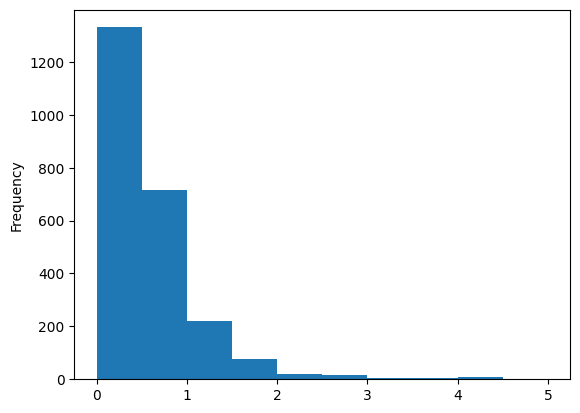

In [48]:
df_test["mae"].plot.hist()

In [49]:
df_test[df_test["mae"] > 3]

,sequence_orig,sequence,label,task,pred,label_float,pred_is_same_sign,mae
137,CAAGGTAGATGGGCTCCATG,CAAGGTAGATGGGCTCCATGAGG,-3.6,BE39:MELJUSO:zscore,0.7,-3.6,False,4.3
297,GGGAGATGTCGCTGAGCAGG,GGGAGATGTCGCTGAGCAGGTGG,0.4,BE39:MELJUSO:zscore,-4.0,0.4,False,4.4
1227,CTATGCTTGTTTCCCGACTG,CTATGCTTGTTTCCCGACTGTGG,-0.1,BE39:MELJUSO:zscore,-4.0,-0.1,True,3.9
1389,CGACCAGATGGAGCTAGGAG,CGACCAGATGGAGCTAGGAGAGG,-4.0,BE39:MELJUSO:zscore,0.4,-4.0,False,4.4
1539,GTCCTCAATTCCTGGAGCAT,GTCCTCAATTCCTGGAGCATCGG,-4.0,BE39:MELJUSO:zscore,0.1,-4.0,False,4.1
1546,AACCCATGGGCCACCTCCCA,AACCCATGGGCCACCTCCCATGG,0.2,BE39:MELJUSO:zscore,-4.0,0.2,False,4.2
1646,TTCACAGCCGCACTTGGCTA,TTCACAGCCGCACTTGGCTAGGG,-3.7,BE39:MELJUSO:zscore,0.3,-3.7,False,4.0
1679,GACGATCAGGGTTTCCAGGA,GACGATCAGGGTTTCCAGGAAGG,-4.0,BE39:MELJUSO:zscore,-0.5,-4.0,True,3.5
1729,ATACCCGGTTCAGCCTGGCT,ATACCCGGTTCAGCCTGGCTCGG,-3.0,BE39:MELJUSO:zscore,0.2,-3.0,False,3.2
1784,GACTCCAGGGAGTTCTGGGA,GACTCCAGGGAGTTCTGGGAGGG,-4.0,BE39:MELJUSO:zscore,0.4,-4.0,False,4.4


In [ ]:
# https://huggingface.co/collections/sapienzanlp/ita-bench-italian-benchmarks-for-llms-66337ca59e6df7d7d4933896